In [1]:
import random
import subprocess
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import datetime
import numpy as np
from collections import defaultdict
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots
from collections import defaultdict
import plotly.express as px

sns.set(style="whitegrid")

![Image](images/original.png) 

![Image](images/bert-like-before.png) 

![Image](images/bert-like-after.png) 

In [2]:
def read_csv(file_name):
    df = pd.read_csv(file_name)
    df.columns = df.columns.str.strip()
    df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
    df = df.sort_values(by=['row', 'col'])
    return df

bert_row_df = read_csv("graph-data/bert-row-10.csv")
bert_col_df = read_csv("graph-data/bert-col-10.csv")
bert_row_col_df = read_csv("graph-data/bert-row-col-10.csv")
bert_row_col_df

,model,row,col,format,prop,before,after,analysis,load,comp,run,memory,tensors
0,bert,0.1,0.1,SparseDense,0,0.065934,0.065934,0.000000,5.734061,0.177376,11.282370,639.5925,284.952
5,bert,0.1,0.1,SparseDense,1,0.065934,0.078746,0.000023,5.736271,0.177532,10.969230,635.2773,283.357
10,bert,0.1,0.1,DD,0,0.065934,0.065934,0.000000,6.229111,0.172621,11.976620,631.7224,288.000
1,bert,0.3,0.3,SparseDense,0,0.195590,0.195590,0.000000,6.355833,0.177852,9.942200,558.6384,278.542
6,bert,0.3,0.3,SparseDense,1,0.195590,0.225578,0.000020,6.416097,0.177603,9.189045,542.6617,273.743
11,bert,0.3,0.3,DD,0,0.195590,0.195590,0.000000,7.971254,0.172426,11.934260,631.7077,288.000
2,bert,0.5,0.5,SparseDense,0,0.321429,0.321429,0.000000,6.903601,0.177174,9.989684,507.7917,272.133
7,bert,0.5,0.5,SparseDense,1,0.321429,0.357143,0.000022,6.953758,0.176944,8.915671,483.8052,264.129
12,bert,0.5,0.5,DD,0,0.321429,0.321429,0.000000,9.628311,0.175053,11.901490,631.6972,288.000
3,bert,0.7,0.7,SparseDense,0,0.443158,0.443158,0.000000,7.321796,0.176893,9.615878,449.8938,265.739


In [8]:
def plot_runtime(data_frame):
    df = data_frame.copy()
    df['sparsity'] = df.apply(lambda row: f"({int(row['row'] * 100)}, {int(row['col'] * 100)})", axis=1)
    df['config'] = df.apply(lambda row: "Dense" if row['format'].strip() == 'DD' else( 'Sparse + Prop' if row['prop'] == 1 else 'Sparse'), axis=1)
    df = df.sort_values(by=['config'])
    fig = go.Figure()

    current_x = 0

    
    for config in df['config'].unique():
        x_positions = []
        x_labels = []
        for i in range(len(df[df['config'] == config])):
            x_positions.append(i * 4 + current_x)
            x_labels.append(i * 4 + 1)
        current_x += 1

        config_data = df[df['config'] == config]
        fig.add_trace(go.Bar(
            x=x_positions,
            y=config_data['run'],
            marker_line_width=1,
            marker_line_color='black',
            opacity=0.9,
            name=config,
            showlegend=True,
            hovertemplate=(
                'Sparsity: %{customdata[13]}<br>' +
                'Format: %{customdata[14]}<br>' +
                'Size: %{y:.3f}s<br>'
            ),
            customdata=config_data,
        ))

    fig.update_layout(
        xaxis=dict(
            tickmode="array",
            tickvals=x_labels,
            ticktext=[i for i in df['sparsity'].unique()],
            showgrid=True,
            gridwidth=1,
            gridcolor='#f0f0f0',
            linecolor='black',
            linewidth=2,
            tickfont=dict(size=12),
            title_text="% Sparsity (Row/Col)",
        ),
        yaxis=dict(
            showgrid=True,
            gridwidth=1,
            gridcolor='#f0f0f0',
            tickfont=dict(size=12),
            title_text="Runtime (s)",
        ),
        plot_bgcolor='white',
        paper_bgcolor='white',
        font=dict(size=11),
        width=500,
        height=250,
        legend=dict(
            orientation="h",
            yanchor="top",
            y=-0.25,
            xanchor="center",
            x=0.5,
            font=dict(size=12),
            itemsizing='trace',
        ),
        margin=dict(t=0, b=0, l=0, r=40),
    )
    fig.show()
    pio.write_image(fig, "bert_tensors.svg", width=500, height=250)


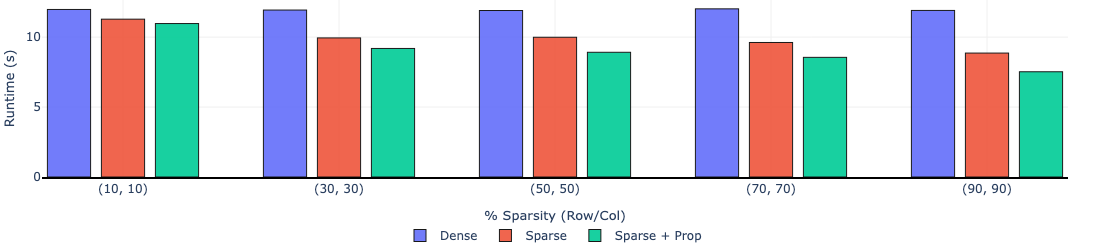

In [9]:
plot_runtime(bert_row_col_df)

In [16]:
def plot_memory(data_frame):
    df = data_frame.copy()
    df['sparsity'] = df.apply(lambda row: f"({int(row['row'] * 100)}, {int(row['col'] * 100)})", axis=1)
    df['config'] = df.apply(lambda row: "Dense" if row['format'].strip() == 'DD' else( 'Sparse + Prop' if row['prop'] == 1 else 'Sparse'), axis=1)
    df = df.sort_values(by=['config'])
    fig = go.Figure()

    current_x = 0

    
    for config in df['config'].unique():
        x_positions = []
        x_labels = []
        for i in range(len(df[df['config'] == config])):
            x_positions.append(i * 4 + current_x)
            x_labels.append(i * 4 + 1)
        current_x += 1

        config_data = df[df['config'] == config]
        fig.add_trace(go.Bar(
            x=x_positions,
            y=config_data['tensors'],
            marker_line_width=1,
            marker_line_color='black',
            opacity=0.9,
            name=config,
            showlegend=True,
            hovertemplate=(
                'Sparsity: %{customdata[13]}<br>' +
                'Format: %{customdata[14]}<br>' +
                'Size: %{y:.3f}MB<br>'
            ),
            customdata=config_data,
        ))

    fig.update_layout(
        xaxis=dict(
            tickmode="array",
            tickvals=x_labels,
            ticktext=[i for i in df['sparsity'].unique()],
            showgrid=True,
            gridwidth=1,
            gridcolor='#f0f0f0',
            linecolor='black',
            linewidth=2,
            tickfont=dict(size=12),
            title_text="% Sparsity (Row/Col)",
        ),
        yaxis=dict(
            showgrid=True,
            gridwidth=1,
            gridcolor='#f0f0f0',
            tickfont=dict(size=12),
            title_text="Tensor sizes (MB)",
        ),
        plot_bgcolor='white',
        paper_bgcolor='white',
        font=dict(size=11),
        width=500,
        height=250,
        legend=dict(
            orientation="h",
            yanchor="top",
            y=-0.25,
            xanchor="center",
            x=0.5,
            font=dict(size=12),
            itemsizing='trace',
        ),
        margin=dict(t=0, b=0, l=0, r=40),
    )
    fig.show()
    pio.write_image(fig, "bert_tensors.svg", width=500, height=250)


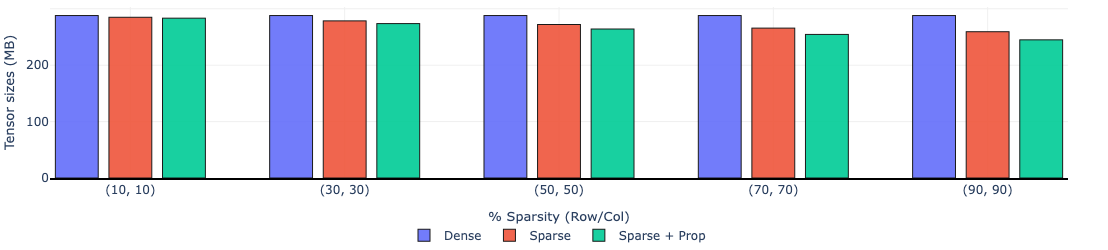

In [17]:
plot_memory(bert_row_col_df)